# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout,RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load & Preprocess Data

In [2]:
data_dir = "data/train"#directory of the  train data
test_dir = "data/test"#directory of the  test data

height,width=224,224#Size of the image
batch_size=64
train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height,width),# resize images after they are read from folder
  batch_size=batch_size)#Size of the batches of data to load at a time

Found 8386 files belonging to 7 classes.
Using 6709 files for training.


In [3]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height,width),
  batch_size=batch_size)

Found 8386 files belonging to 7 classes.
Using 1677 files for validation.


In [4]:

# Add data augmentation as part of your model or preprocessing pipeline
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2)
])

In [5]:
# Apply augmentation to the training dataset
train_dataset_augmented = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
class_names=train_dataset.class_names
print(class_names)

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


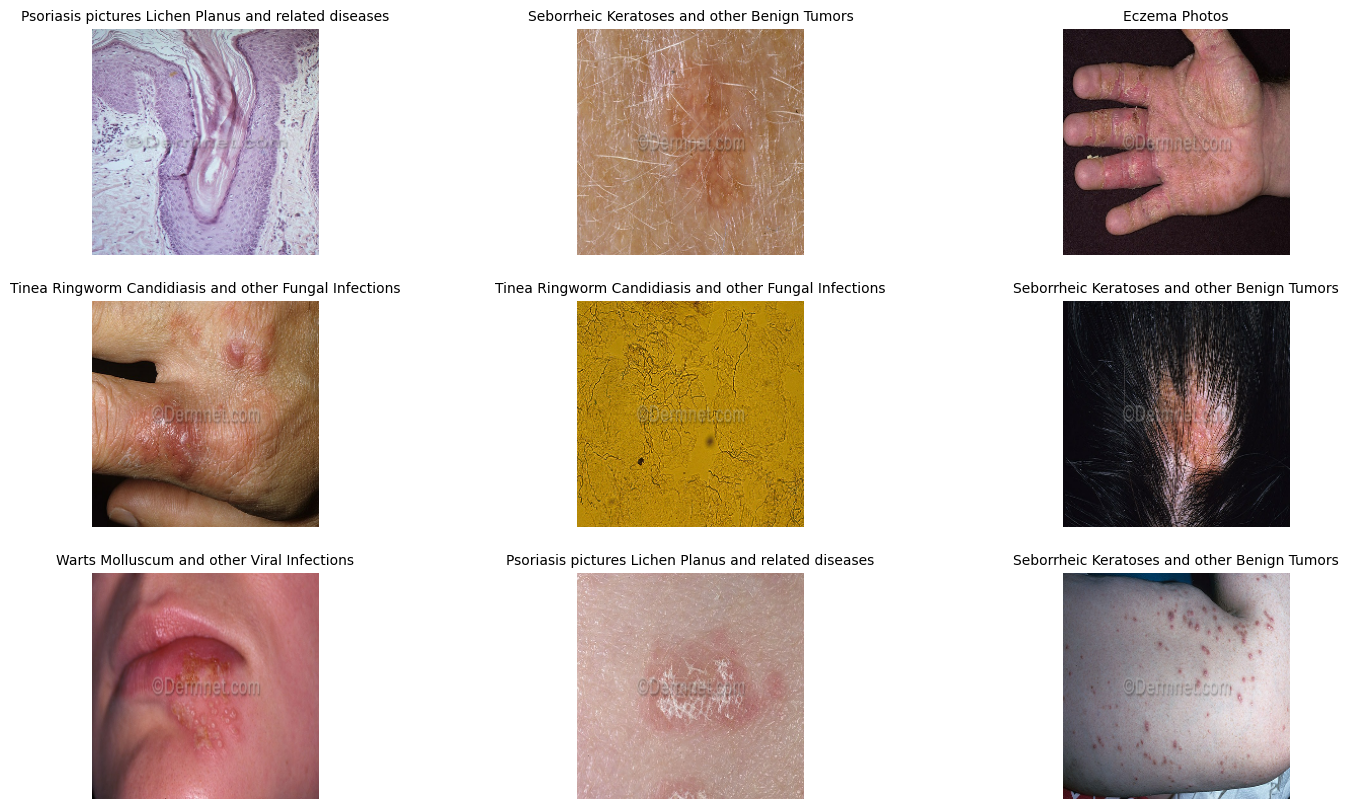

In [7]:
plt.figure(figsize = (10,10))#setting the size images in plot only
for images, labels in train_dataset.take(1):#looping through the dataset
   for i in range(9):
     ax = plt.subplot(3,3,i+1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(class_names[labels[i]],fontsize = 10)
     plt.subplots_adjust(right =1.5)   
     plt.axis("off")

In [8]:
location = Path('data/train')
array = []
for folders in location.glob("*"):
    row = {}
    row["disease"] = folders.name.replace("Photos", "")
    list = os.listdir(folders) 
    countFiles = len(list)
    row["count"] =countFiles
    array.append(row)  
df=pd.DataFrame(array) 
print(df)

                                             disease  count
0                                  Acne and Rosacea     840
1  Actinic Keratosis Basal Cell Carcinoma and oth...   1149
2                                            Eczema    1235
3  Psoriasis pictures Lichen Planus and related d...   1405
4       Seborrheic Keratoses and other Benign Tumors   1371
5  Tinea Ringworm Candidiasis and other Fungal In...   1300
6         Warts Molluscum and other Viral Infections   1086


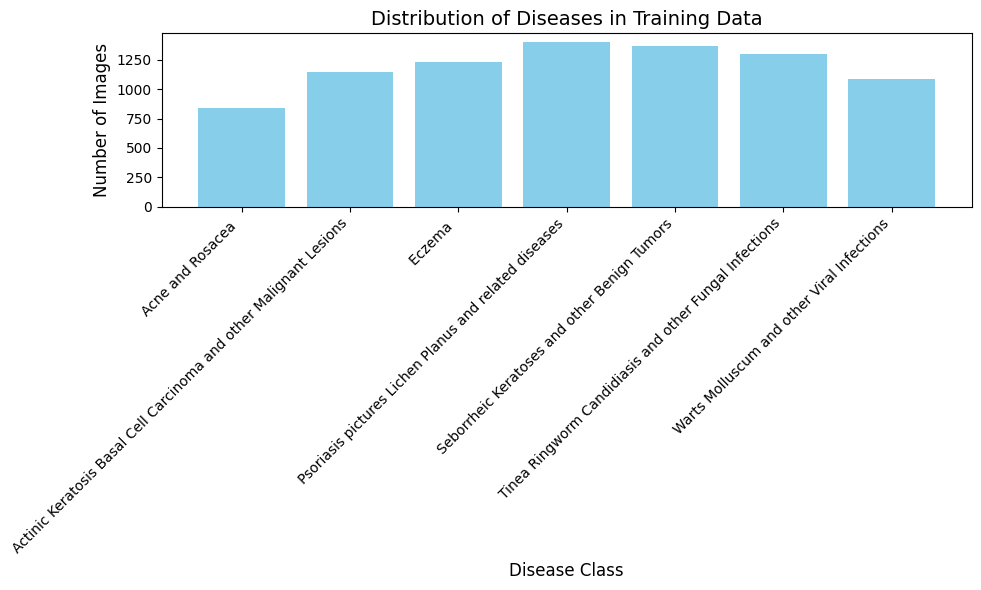

In [9]:
# Step 1: Plotting a Bar Chart
plt.figure(figsize=(10, 6))

# Step 2: Create the bar chart
plt.bar(df["disease"], df["count"], color='skyblue')

# Step 3: Adding labels and title
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Diseases in Training Data', fontsize=14)

# Step 4: Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Step 5: Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

# Load Model + Add Layers

In [10]:
model= Sequential()

resnet_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=7,
                   weights='imagenet')

for layer in resnet_model.layers:
        layer.trainable=False
     

In [11]:
model.add(resnet_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))#output layer

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,780,167 (94.53 MB)

 Trainable params: 1,187,335 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Training

In [15]:
epochs=100
history=model.fit(train_dataset,validation_data=val_dataset,epochs=epochs,callbacks=[early_stopping])

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.3148 - loss: 5.1504 - val_accuracy: 0.4711 - val_loss: 3.5084
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - accuracy: 0.4858 - loss: 3.2686 - val_accuracy: 0.5247 - val_loss: 2.5553
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.5632 - loss: 2.3178 - val_accuracy: 0.5450 - val_loss: 2.0188
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6224 - loss: 1.7371 - val_accuracy: 0.5587 - val_loss: 1.7137
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6930 - loss: 1.3703 - val_accuracy: 0.5772 - val_loss: 1.5631
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7170 - loss: 1.1438 - val_accuracy: 0.5880 - val_loss: 1.4977
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7621 - loss: 0.9667 - val_accuracy: 0.5933 - val_loss: 1.4766
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.8037 - loss: 0.8408 - 

# Model Evaluation

Text(0.5, 1.0, 'Training and Validation Accuracy')

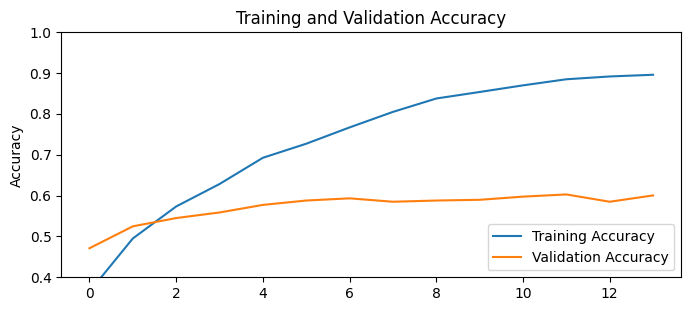

In [21]:
#plotting the learning curves training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.axis(ymin=0.4,ymax=1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

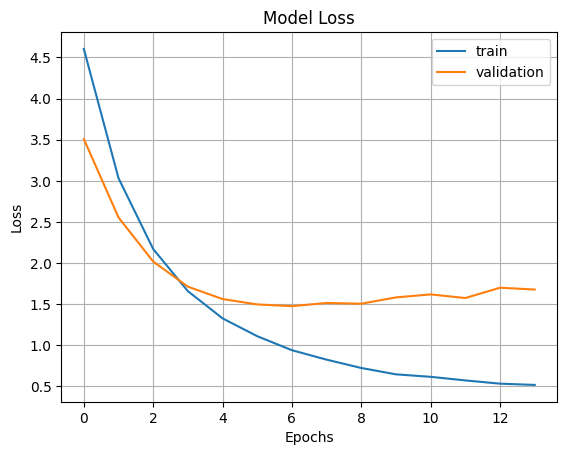

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [23]:
model.save("./resnet_v10.keras");

In [19]:
#testing model accuracy with the testing set(unbiased)
score =model.evaluate(test_dataset)
print('Test accuracy:', score[1])

NameError: name 'test_dataset' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


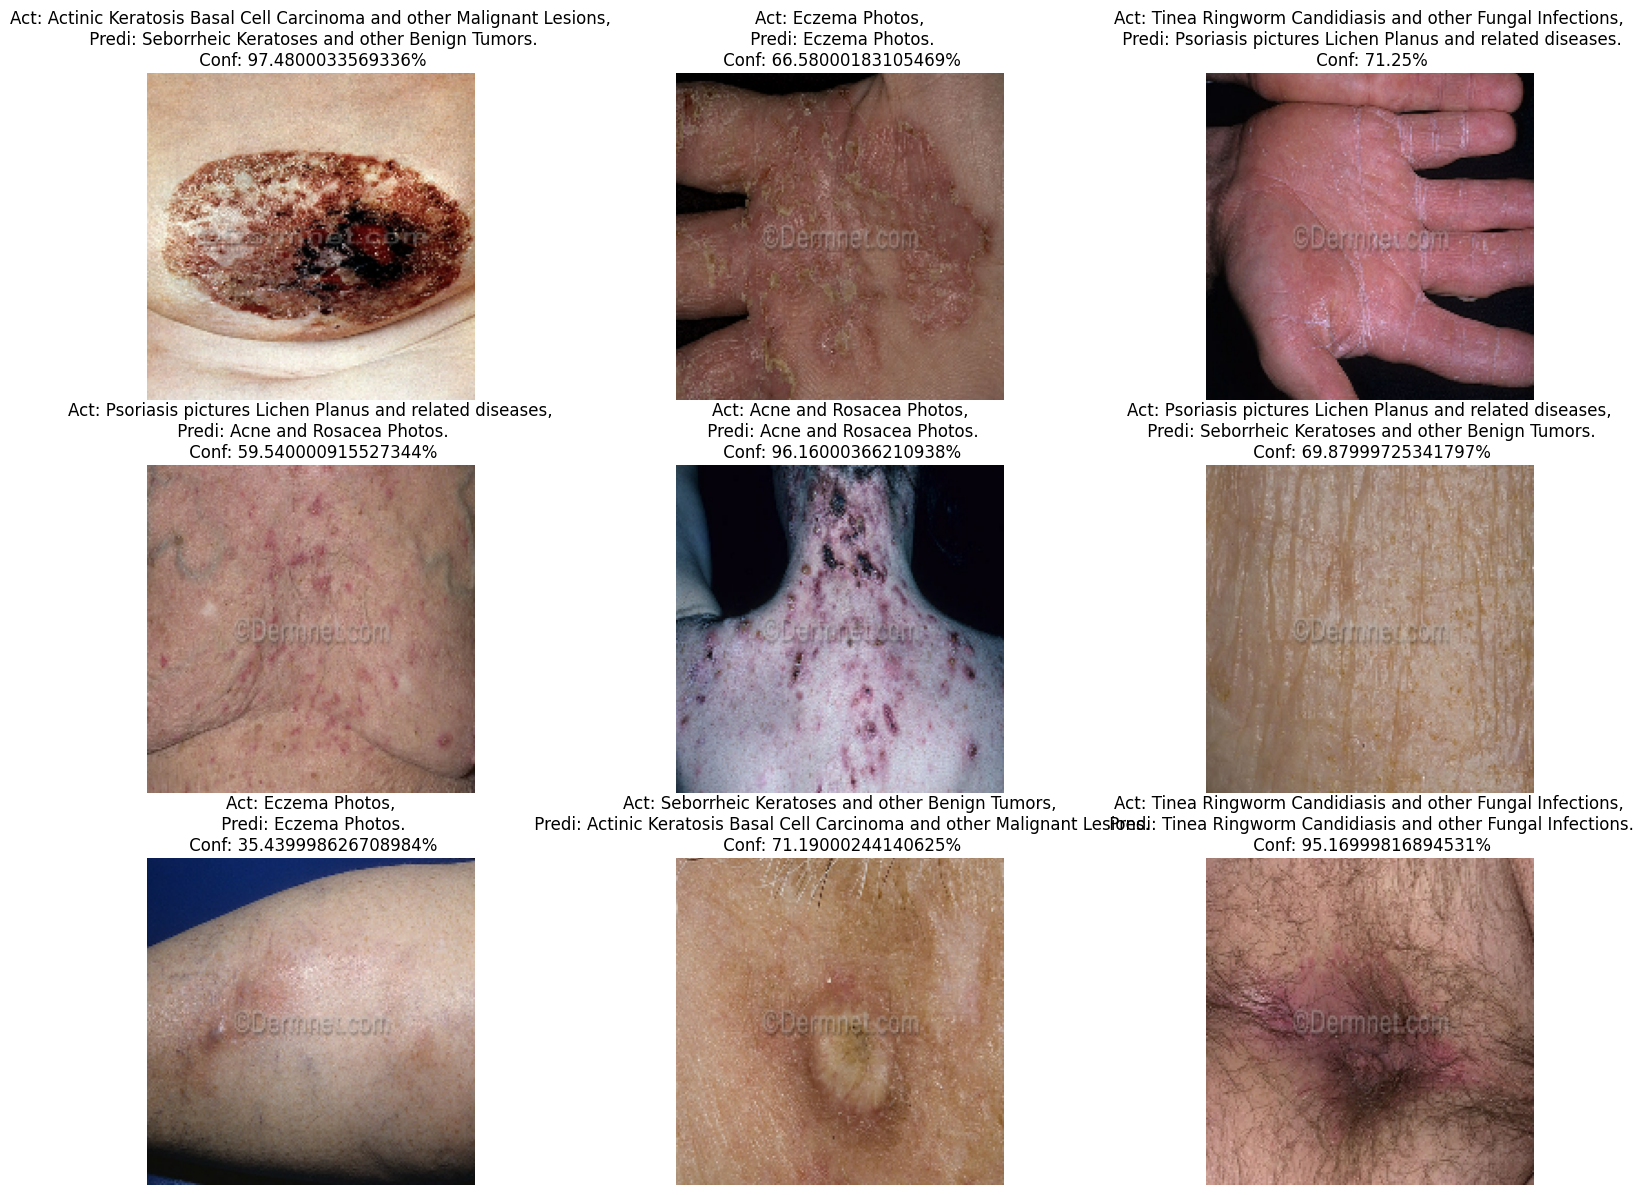

In [21]:
#predicting multiple images
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.subplots_adjust(right =2,top=1.5)
        plt.title(f"Act: {actual_class},\n Predi: {predicted_class}.\n Conf: {confidence}%")
        plt.axis("off")